## Overview
In this project, I've engineered an adaptive machine learning algorithm that undergoes biannual recalibration to select the most accurate model for sector-based investment strategies. To counteract the pitfalls of over-forecasting, the algorithm employs a custom loss function that penalizes overpredictions. It comprehensively integrates a diverse range of financial indicators, including equity, debt, commodities, and market volatility. To enhance computational efficiency and model precision, I employed Principal Component Analysis for feature reduction. The model's robustness was substantiated through a 15-year backtest, during which it outperformed the SPY index by an estimated 91.85%. The finalized, vetted model has been encapsulated in a real-time dashboard.

## Business Understanding: Adaptive Sector Selection
Current investment models are hampered by their inability to adapt swiftly to market changes, making them less predictive and more risky. This maladaptation is a significant drawback, as today's markets are influenced by a myriad of dynamic factors, from tech advances to geopolitical shifts.

Risk management, often sidelined, is crucial for portfolio resilience, especially in volatile markets. Without rigorous risk metrics, even sophisticated models can fail, jeopardizing significant investments.

Lastly, the Efficient-Market Hypothesis (EMH), though foundational, is increasingly scrutinized. It assumes a static, fully rational market, ignoring behavioral factors and information fluidity that can create exploitable inefficiencies. 

This project attempts to mitigate such limitations by employing a machine learning-driven "model of models" framework. This ensemble of algorithms undergoes biannual retraining and evaluation. The best-performing model is then selected for the next six-month cycle, ensuring the investment strategy continually adapts to current market conditions.

Once the leading model is identified, it selects the investment sector based on its predicted mean returns, specifically targeting the sector forecasted to yield the highest return. This dynamic, model-driven sector selection aims to optimize investment outcomes by leveraging timely and precise machine learning predictions.

The strategy is then tested via a 15-year backtest, offering empirical validation of its sector-based approach. Thus, the framework's utility manifests in its ability to not only adapt to market vicissitudes but also pinpoint the most promising sectors for investment based on forecasts.

---

## 1. Data, Features, and Targets
This notebook goes through the process of fetching price data via `yfinance` and the engineering of the features used as model inputs:
1. [Price Retrieval](#price-retrieval)
2. [Log Return Computation](#log-return-computation)
3. [Feature / Target Engineering](#feature--target-engineering)
4. [Handling Multicollinearity](#handling-multicollinearity)

The below are the necessary imports:

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# yfinance for price retrieval
import yfinance as yf

# Datetime
from datetime import datetime as dt

# Suppress warnings 
import warnings
warnings.filterwarnings("ignore")

# Custom functions
from workflow.tools.utils import test_stationarity, set_plot_style

set_plot_style()

### Price Retrieval

I started by reading in the S&P 500 table from Wikipedia using `pandas`, segregating the ticker symbols and their corresponding sectors. To ensure consistency in the ticker symbols, I replaced any periods with hyphens. With the tickers in hand, I then used `yfinance` to download the adjusted closing prices for these companies from January 1, 1990, to September 12, 2023.

In parallel, I also fetched prices for key financial indices: Stocks (VTI), Bonds (AGG), Commodities (DBC), and Volatility (^VIX). The data was stored in a separate dataframe called indices_prices. To align the time frames of the stock and index data, I reindexed the snp_prices dataframe to match the index of indices_prices.

In [3]:
# Read in the S&P 500 table from wikipedia
snp_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
snp_table = pd.read_html(snp_url)[0]

snp_table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
# Segregate tickers and sectors
snp_tickers = snp_table["Symbol"].to_list()
snp_tickers = [ticker.replace('.', "-") for ticker in snp_tickers]
snp_tickers_by_sector = snp_table[["Symbol", "GICS Sector"]]

snp_tickers_by_sector.head()

,Symbol,GICS Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care
3,ABBV,Health Care
4,ACN,Information Technology


In [5]:
# Retrieve prices
start_date = "1990-01-01"
end_date = dt.now().strftime("%Y-%m-%d")

snp_prices = yf.download(snp_tickers, start_date, end_date)["Adj Close"]

[*********************100%%**********************]  503 of 503 completed


In [6]:
snp_prices.head(3)

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,0.263761,NaN,NaN,1.837211,NaN,NaN,1.188340,1.021221,...,NaN,4.175379,4.034967,0.852354,NaN,NaN,NaN,NaN,1.818956,NaN
1990-01-03,NaN,NaN,0.265531,NaN,NaN,1.843845,NaN,NaN,1.247023,0.968170,...,NaN,4.162492,3.994617,0.852354,NaN,NaN,NaN,NaN,1.851438,NaN
1990-01-04,NaN,NaN,0.266417,NaN,NaN,1.840527,NaN,NaN,1.305707,0.954908,...,NaN,4.059397,3.954267,0.818259,NaN,NaN,NaN,NaN,1.851438,NaN


In [7]:
len(snp_prices)

8505

In [8]:
# Retrieve prices for indices
indices = {
    "VTI": "STOCKS",
    "AGG": "BONDS",
    "DBC": "COMMODITIES",
    "^VIX": "VOLATILITY"
}

indices_prices = yf.download(list(indices.keys()), start_date, end_date)["Adj Close"].dropna()
indices_prices.rename(columns=indices, inplace=True)

indices_prices.head(3)

[*********************100%%**********************]  4 of 4 completed


,BONDS,COMMODITIES,STOCKS,VOLATILITY
Date,,,,
2006-02-06,58.557709,21.916014,45.302418,13.04
2006-02-07,58.516792,21.282080,44.861347,13.59
2006-02-08,58.487572,21.191517,45.184078,12.83


In [9]:
len(indices_prices)

4446

In [10]:
# Reindex prices to match index prices
snp_prices = snp_prices.reindex(indices_prices.index).dropna(axis=1)
snp_prices.head()

,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-02-06,21.113106,27.594044,2.040143,13.528107,6.003333,23.419563,39.520000,25.989529,19.771854,22.702057,...,60.554249,13.990586,34.024212,9.773682,33.966377,23.227768,13.171964,58.666470,43.349998,58.166367
2006-02-07,20.663372,27.339502,2.049238,13.429242,5.937778,23.639194,39.259998,26.118895,19.871241,22.846323,...,61.343208,13.916320,33.315838,9.627960,33.188072,23.241030,13.014938,59.159023,44.000000,57.862614
2006-02-08,20.991564,28.272818,2.085918,13.413297,5.885556,23.749004,38.799999,26.455254,20.288677,23.258528,...,62.482754,13.990586,33.167564,9.529078,33.276230,23.298456,12.865629,59.484478,46.180000,58.307163
2006-02-09,21.350136,28.612202,1.968905,13.441998,5.922222,23.236540,38.119999,26.461710,20.739237,23.511011,...,60.975018,13.974533,32.711792,9.700820,33.017250,24.102455,12.685439,60.205688,45.880001,58.722023
2006-02-10,21.799866,28.282249,2.040447,13.544047,5.951111,23.404924,38.689999,25.394440,20.354925,23.547064,...,61.045151,13.900264,32.673340,9.674798,32.747257,24.261482,12.888801,60.267254,45.849998,59.270279


### Log Return Computation

In the next phase, I computed the logarithmic returns for both the S&P 500 stocks and the financial indices. I calculated the log returns by taking the difference of the log of consecutive prices:

$$R_{\text{log}} = \text{ln}\Bigl(\frac{P_{t}}{P_{t-1}}\Bigl)$$

This was done for both the `indices_prices` and `snp_prices` dataframes. Log returns normalize price data and make it stationary, a pre-requisite for time-series modeling.

In [11]:
# Compute log returns
indices_log_returns = np.log(indices_prices).diff()[1:]
snp_log_returns = np.log(snp_prices).diff()[1:]

In [12]:
snp_log_returns.head(3)

,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-02-07,-0.021531,-0.009267,0.004448,-0.007335,-0.010980,0.009334,-0.006601,0.004965,0.005014,0.006335,...,0.012945,-0.005322,-0.021039,-0.015022,-0.023181,0.000571,-0.011993,0.008361,0.014883,-0.005236
2006-02-08,0.015758,0.033568,0.017741,-0.001188,-0.008834,0.004634,-0.011786,0.012796,0.020789,0.017882,...,0.018406,0.005322,-0.004460,-0.010323,0.002653,0.002468,-0.011538,0.005486,0.048357,0.007653
2006-02-09,0.016937,0.011932,-0.057731,0.002137,0.006210,-0.021815,-0.017681,0.000244,0.021964,0.010797,...,-0.024426,-0.001148,-0.013837,0.017862,-0.007813,0.033927,-0.014105,0.012051,-0.006517,0.007090


In [13]:
indices_log_returns.head(3)

,BONDS,COMMODITIES,STOCKS,VOLATILITY
Date,,,,
2006-02-07,-0.000699,-0.029352,-0.009784,0.041313
2006-02-08,-0.000499,-0.004264,0.007168,-0.057548
2006-02-09,0.000599,0.009358,-0.001907,0.022352


### Feature / Target Engineering

For feature and target engineering, I started by making a copy of the `snp_tickers_by_sector` dataframe and converting the sector names to uppercase while replacing spaces with underscores. This allows for easier manipulation and better readability.

The features are initiated by copying the `indices_log_returns` dataframe, which already contains the log returns for key financial indices. Then, I loop through each unique sector in the GICS table. For each sector, I filter out the tickers that are available in the `snp_log_returns` dataframe and calculate the mean log return for that sector on a day-to-day basis. These sector-based mean returns serve as my targets.

Next, I calculated the rolling mean return and standard deviation over a 10-day lookback period for each column in the features dataframe. These values are annualized by multiplying with 252 (the typical number of trading days in a year) and the square root of 252, respectively. I then compute the Sharpe ratio for each feature and add it to the dataframe.

I also incorporated time-lagged features, ranging from one to four fiscal quarters, to account for seasonality and longer-term trends. Finally, I dropped any rows with missing values to clean up the dataset.

To ensure the data is fit for time-series modeling, I ran a stationarity test (via the [Augmented Dickey-Fuller Test](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)) on the engineered features. All features were confirmed to be stationary, meeting a critical precondition for effective modeling.

In [14]:
sectors = snp_tickers_by_sector.copy()
sectors["GICS Sector"] = sectors["GICS Sector"].str.upper().str.replace(" ", "_")
sectors

,Symbol,GICS Sector
0,MMM,INDUSTRIALS
1,AOS,INDUSTRIALS
2,ABT,HEALTH_CARE
3,ABBV,HEALTH_CARE
4,ACN,INFORMATION_TECHNOLOGY
...,...,...
498,YUM,CONSUMER_DISCRETIONARY
499,ZBRA,INFORMATION_TECHNOLOGY
500,ZBH,HEALTH_CARE
501,ZION,FINANCIALS


In [15]:
# Start by copying the indices_log_returns dataframe as a base for the features.
features = indices_log_returns.copy()

# Get the list of tickers that are available in snp_log_returns.
available_tickers = snp_log_returns.columns.to_list()

# Loop through each unique GICS Sector to add sector-based features.
for sector in sectors["GICS Sector"].unique():
    # Get all stocks belonging to the current sector.
    sector_stocks_all = sectors[sectors["GICS Sector"] == sector]["Symbol"].to_list()
    
    # Filter out the available stocks for the current sector.
    available_sector_stocks = [stock for stock in sector_stocks_all if stock in available_tickers]
    
    # Calculate the mean log return for the current sector.
    sector_constituent_returns = snp_log_returns[available_sector_stocks].mean(axis=1)
    
    # Add the mean log return of the current sector to the features dataframe.
    features[f"{sector.upper().replace(' ', '_')}"] = sector_constituent_returns

# Define the lookback period for rolling metrics.
lookback = 10

# Calculate the Sharpe ratio for each feature.
for col in features.columns:
    # Calculate the annualized rolling mean return.
    rolling_mean_return = features[col].rolling(lookback).mean() * 252
    
    # Calculate the annualized rolling standard deviation.
    rolling_std = features[col].rolling(lookback).std() * np.sqrt(252)
    
    # Compute the Sharpe ratio and add it to the features dataframe.
    features[f"{col}_SHARPE"] = rolling_mean_return / rolling_std

# Add time-lagged features to capture seasonality and trends.
for col in features.columns:
    for i in range(63, 252, 63):
        # Add features with lags ranging from 1 to 4 quarters (63 to 252 days).
        features[f"{col}_LAG_{int(i/63)}Q"] = features[col].shift(i)

# Remove rows with missing values.
features = features.dropna()

display(features.head(3))
print(features.shape)

,BONDS,COMMODITIES,STOCKS,VOLATILITY,INDUSTRIALS,HEALTH_CARE,INFORMATION_TECHNOLOGY,COMMUNICATION_SERVICES,CONSUMER_STAPLES,UTILITIES,...,CONSUMER_DISCRETIONARY_SHARPE_LAG_3Q,MATERIALS_SHARPE_LAG_1Q,MATERIALS_SHARPE_LAG_2Q,MATERIALS_SHARPE_LAG_3Q,REAL_ESTATE_SHARPE_LAG_1Q,REAL_ESTATE_SHARPE_LAG_2Q,REAL_ESTATE_SHARPE_LAG_3Q,ENERGY_SHARPE_LAG_1Q,ENERGY_SHARPE_LAG_2Q,ENERGY_SHARPE_LAG_3Q
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-17,0.002596,0.012310,-0.000504,-0.010886,-0.004545,0.000910,-0.005077,-0.000377,-0.002383,0.001344,...,2.428570,2.084676,-15.612330,1.238721,2.115906,-11.428881,5.667042,-2.995586,-10.018008,-2.960261
2006-11-20,0.000697,-0.003677,0.000576,-0.007992,-0.003783,-0.002609,0.004160,-0.000719,-0.000674,0.000208,...,8.980478,4.024577,-16.161492,5.142285,5.496832,-12.391285,10.756696,-1.349368,-11.089579,-1.268235
2006-11-21,0.001294,0.009371,0.002587,-0.007046,0.005858,-0.000898,0.000011,0.004655,-0.001123,0.001681,...,6.570777,4.189588,-16.598577,5.186123,6.075871,-12.975614,11.345138,-5.148563,-14.467736,-1.102510


(4247, 120)


In [16]:
# Conduct stationary test
stationarity_test = test_stationarity(features)

for result in stationarity_test.values:
    assert result == "Stationary"

  0%|          | 0/120 [00:00<?, ?it/s]

### Handling Multicollinearity

Multicollinearity can be detrimental to machine learning models for several reasons:

- **Interpretability**: Highly correlated features make it difficult to discern the individual impact of each feature on the target variable.

- **Overfitting**: Multicollinearity can lead to overfitting, where the model learns the noise in the data rather than the actual relationships between variables. This undermines the model's generalizability to new data.

- **Statistical Inference**: In algorithms that rely on statistical significance, multicollinearity can distort p-values for the features, leading to incorrect conclusions about the importance of variables.

- **Model Stability**: Multicollinearity can make the model's estimates very sensitive to slight changes in the data, resulting in a lack of robustness.

- **Computational Overheads**: High correlation among features adds redundancy, making the model computationally expensive without contributing much to predictive power.

To assess the multicollinearity among the features, I employed a heatmap using Seaborn to visualize the correlation matrix. The heatmap indicated substantial correlation between several features.

In [17]:
df = features.copy()

df.head()

,BONDS,COMMODITIES,STOCKS,VOLATILITY,INDUSTRIALS,HEALTH_CARE,INFORMATION_TECHNOLOGY,COMMUNICATION_SERVICES,CONSUMER_STAPLES,UTILITIES,...,CONSUMER_DISCRETIONARY_SHARPE_LAG_3Q,MATERIALS_SHARPE_LAG_1Q,MATERIALS_SHARPE_LAG_2Q,MATERIALS_SHARPE_LAG_3Q,REAL_ESTATE_SHARPE_LAG_1Q,REAL_ESTATE_SHARPE_LAG_2Q,REAL_ESTATE_SHARPE_LAG_3Q,ENERGY_SHARPE_LAG_1Q,ENERGY_SHARPE_LAG_2Q,ENERGY_SHARPE_LAG_3Q
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-17,0.002596,0.012310,-0.000504,-0.010886,-0.004545,0.000910,-0.005077,-0.000377,-0.002383,0.001344,...,2.428570,2.084676,-15.612330,1.238721,2.115906,-11.428881,5.667042,-2.995586,-10.018008,-2.960261
2006-11-20,0.000697,-0.003677,0.000576,-0.007992,-0.003783,-0.002609,0.004160,-0.000719,-0.000674,0.000208,...,8.980478,4.024577,-16.161492,5.142285,5.496832,-12.391285,10.756696,-1.349368,-11.089579,-1.268235
2006-11-21,0.001294,0.009371,0.002587,-0.007046,0.005858,-0.000898,0.000011,0.004655,-0.001123,0.001681,...,6.570777,4.189588,-16.598577,5.186123,6.075871,-12.975614,11.345138,-5.148563,-14.467736,-1.102510
2006-11-22,0.001391,0.003643,0.002795,0.023953,0.004304,0.002980,0.007767,0.004901,0.004448,0.001749,...,7.028660,2.803061,-7.241054,4.658656,7.667701,-4.518201,12.016759,-2.352484,-6.372538,3.605203
2006-11-24,0.000298,0.013644,-0.002938,0.056555,-0.001667,-0.002581,-0.002647,-0.003594,-0.002404,0.002366,...,8.116906,5.187136,-3.555746,4.377718,10.445835,-0.992765,12.241260,-0.383959,-3.187976,2.030936


In [18]:
y = df[sectors["GICS Sector"].unique()]
X = df[df.columns[~df.columns.isin(sectors)]]

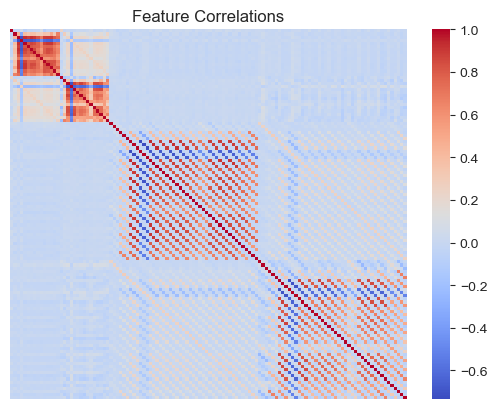

In [19]:
# Check feature correlation
sns.heatmap(X.corr(), cmap="coolwarm")
plt.xticks([])
plt.yticks([])
plt.title("Feature Correlations")
plt.show()

Though the heatmap revealed pronounced multicollinearity, I chose not to address it at this juncture. Instead, I manage this aspect during the modeling phase by incorporating Principal Component Analysis (PCA) into the pipeline. This strategy allows for dimensionality reduction and decorrelation of features without sacrificing significant information, thereby mitigating the impact of multicollinearity on the model's performance.

In [20]:
# Saving the master dataframe and SNP returns
df.to_csv("workflow/data/master_df.csv")

snp_log_returns = snp_log_returns.reindex(df.index)
snp_log_returns.to_csv("workflow/data/snp_log_returns.csv")